# 

# British National Grid Indexing Polygon Examples: `osbng.indexing`

The indexing functions within the `osbng` package are part of the `osbng.indexing` module. The `geom_to_bng` and `geom_to_bng_intersection` functions enable the indexing of geometries, represented using [`Shapely`](https://github.com/shapely/shapely/) Geometry objects, into grid squares at a specified resolution. Both functions accept Shapely Geometry objects of the following types: `Point`, `LineString`, `Polygon`, `MultiPoint`, `MultiLineString`, `MultiPolygon`, and `GeometryCollection`. The geometry coordinates must be encoded in the [British National Grid (OSGB36) EPSG:27700](https://epsg.io/27700) coordinate reference system.

These functions facilitate grid-based spatial analysis, enabling applications such as statistical aggregation, data visualisation, and data interoperability. The two functions differ in their operation: `geom_to_bng` returns the BNG grid squares intersected by the input geometry, while `geom_to_bng_intersection` returns the intersections (shared areas) between the input geometry and the grid square geometries.

When deciding between the two functions, consider whether a decomposition of the input geometry by BNG grid squares is required. The decomposition logic is computationally more expensive but is useful when the intersection between the input geometry and a grid square is needed. This approach supports spatial join optimisations, such as point-in-polygon and polygon-to-polygon operations, using the `is_core` property of the `BNGIndexedGeometry` object. These optimisations are particularly valuable for geospatial analysis of medium to large datasets in distributed processing systems, where geometries may be colocated by their BNG references.

## Indexing Functions Accepting Shapely Geometries

### geom_to_bng

This function returns a list of `BNGReference` objects representing the BNG grid squares intersected by the input geometry. Note that `BNGReference` objects are deduplicated in cases where multiple parts of a multi-part geometry intersect the same grid square.

### geom_to_bng_intersection

This function returns a list of `BNGIndexedGeometry` objects representing the decomposition of the input geometry into BNG grid squares. Unlike `geom_to_bng`, no deduplication occurs. If multiple parts of a multi-part geometry intersect the same grid square, the intersection for each part is returned.

## Examples

The examples below demonstrate the application of the two indexing functions using the London boundary from the administrative England Regions dataset provided by the Office for National Statistics (ONS). Metadata for this dataset is available in `examples/data/metadata.json`. The indexing functions are applied to geometries within a [`GeoPandas`](https://github.com/geopandas/geopandas) GeoDataFrame. No geometry conversion is required, as the geometries are stored as arrays of Shapely geometry objects.

## Optional GeoPandas Dependency

While `osbng` is fully compatible with `GeoPandas` and can seamlessly work with GeoDataFrames, it does not require `GeoPandas` as a hard dependency. The indexing functions operate directly on Shapely Geometry objects. This allows you to use these functions with standard Python data structures (e.g., lists, dictionaries) containing Shapely geometries.

In [2]:
import geopandas as gpd
from matplotlib import patheffects, pyplot as plt
from matplotlib.lines import Line2D

from osbng.indexing import geom_to_bng, geom_to_bng_intersection

/home/skingston/miniconda3/envs/osbng-ecosystem/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [ ]:
# Read the Office for National Statistics (ONS) England Regions GeoPackage
# Create a GeoPandas GeoDataFrame
# See examples/data/metadata.json for more information about the data source
gdf = gpd.read_file("../data/Regions_December_2024_Boundaries_EN_BFC.gpkg")

# Convert column names to lowercase
gdf.columns = gdf.columns.str.lower()

# Filter the GeoDataFrame
# Keep only the Greater London region
gdf_london = gdf[gdf["rgn24nm"] == "London"][["rgn24cd", "rgn24nm", "geometry"]]

# Return GeoDataFrame
gdf_london

,rgn24cd,rgn24nm,geometry
6,E12000007,London,"MULTIPOLYGON (((531024.595 200933.623, 531023...."


In [6]:
# osbng.indexing functions require geometry coordinates to be specified 
# in British National Grid (BNG) (OSGB36) cordinate reference system
# EPSG:27700
# https://epsg.io/27700
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### geom_to_bng

Returns a list of `BNGReference` objects representing the BNG grid squares intersected by the input geometry. The `BNGReference` provides properties and methods to access and manipulate the reference. This includes the following property and method used below:

* `bng_ref_compact`: The BNG reference with whitespace removed.
* `bng_to_grid_geom()`:  Returns a grid square as a `Shapely` Polygon.

In [ ]:
# Create a copy of the GeoDataFrame
_gdf_london = gdf_london.copy()

# Return the BNG grid squares intersected by the London Region
# Uses the geom_to_bng function from the osbng.indexing module
# Returns a list of BNGReference objects
_gdf_london["bng_ref_5km"] = _gdf_london["geometry"].apply(
    lambda x: geom_to_bng(geom=x, resolution="5km")
)

# Drop the original geometry column
_gdf_london = _gdf_london.drop(columns=["geometry"])

# Explode the bng_ref_5km column to separate rows for each BNGIndexedGeometry object
_gdf_london_exp = _gdf_london.explode("bng_ref_5km", ignore_index=True)

# Extract the bng_ref_compact BNGReference property into a new column
_gdf_london_exp["bng_ref_compact"] = _gdf_london_exp["bng_ref_5km"].apply(lambda x: x.bng_ref_compact)
# Return the grid square geometry for each BNGReference object
_gdf_london_exp["geometry"] = _gdf_london_exp["bng_ref_5km"].apply(lambda x: x.bng_to_grid_geom())

# Drop the original bng_ref_5km column
_gdf_london_exp = _gdf_london_exp.drop(columns=["bng_ref_5km"])

# Set the geometry column to the new geometry column
_gdf_london_exp = _gdf_london_exp.set_geometry("geometry")
# Set the CRS to British National Grid (OSGB36)
_gdf_london_exp = _gdf_london_exp.set_crs(27700)

# Return the first few rows of the GeoDataFrame
_gdf_london_exp.head()

,rgn24cd,rgn24nm,bng_ref_compact,geometry
0,E12000007,London,TQ16NW,"POLYGON ((515000 165000, 515000 170000, 510000..."
1,E12000007,London,TQ27SW,"POLYGON ((525000 170000, 525000 175000, 520000..."
2,E12000007,London,TQ27NE,"POLYGON ((530000 175000, 530000 180000, 525000..."
3,E12000007,London,TQ17NW,"POLYGON ((515000 175000, 515000 180000, 510000..."
4,E12000007,London,TQ38SE,"POLYGON ((540000 180000, 540000 185000, 535000..."


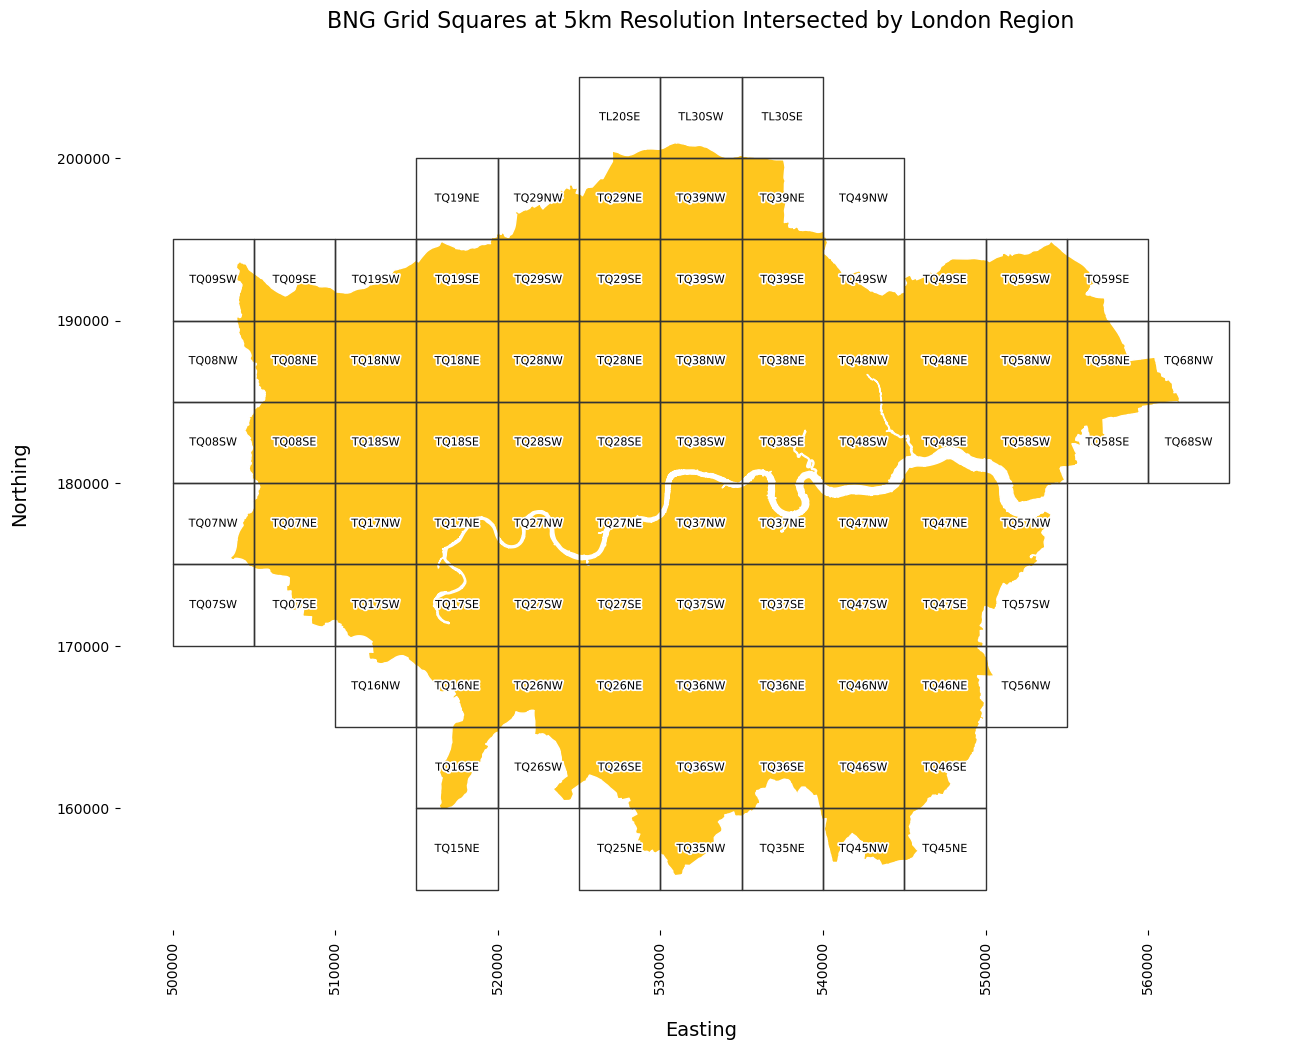

In [9]:
# Create matplotlib figure and axis
f, ax = plt.subplots(figsize=(15, 15))

# Plot the London Region GeoDataFrame
gdf_london.plot(
    ax=ax,
    color="#ffc61e",
    edgecolor="#fff",
    linewidth=1,
)
# Plot the indexed and exploded London Region GeoDataFrame
_gdf_london_exp.plot(
    ax=ax,
    edgecolor="#333333",
    facecolor="none",
    linewidth=1,
)

# Add feature labels with white halo
for idx, row in _gdf_london_exp.iterrows():
    ax.text(
        row["geometry"].centroid.x,
        row["geometry"].centroid.y,
        row["bng_ref_compact"],
        fontsize=8,
        ha="center",
        va="center",
        path_effects=[patheffects.withStroke(linewidth=2.5, foreground="white")]
    )

# Set the title
ax.set_title("BNG Grid Squares at 5km Resolution Intersected by London Region", fontsize=16)

# Set axis labels
ax.set_xlabel("Easting", fontsize=14)
ax.set_ylabel("Northing", fontsize=14)

# Remove the figure frame but keep the ticks and tick labels
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Disable scientific notation for both axes
ax.ticklabel_format(style="plain", axis="both")

# Rotate x axis tick labels by 90 degrees anticlockwise
plt.xticks(rotation=90)

# Add whitespace between x and y axis labels and tick labels
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

### geom_to_bng_intersection

Returns a list of `BNGIndexedGeometry` objects representing the decomposition of the input geometry into BNG grid squares. The three properties of the `BNGIndexedGeometry` object are:

* `bng_ref`: The `BNGReference` object representing the grid square corresponding to the decomposition.
* `is_core`:  A Boolean flag indicating whether the grid square geometry is entirely contained by the input geometry. This is relevant for Polygon geometries and helps distinguish between "core" (fully inside)and "edge" (partially overlapping) grid squares.
* `geom`: The `Shapely` Geometry representing the intersection between the input geometry and the grid square. This can one of a number of geometry types depending on the overlap. When `is_core` is True, geom is the same as the grid square geometry.

In [11]:
# Create a copy of the GeoDataFrame
_gdf_london = gdf_london.copy()

# Decompose the London Region into a simplified representation
# bounded by its presence in each BNG grid square at a 5km resolution
# Uses the geom_to_bng_intersection function from the osbng.indexing module
# Returns a list of BNGIndexedGeometry objects
_gdf_london["bng_ref_5km"] = _gdf_london["geometry"].apply(
    lambda x: geom_to_bng_intersection(geom=x, resolution="5km")
)

# Drop the original geometry column
_gdf_london = _gdf_london.drop(columns=["geometry"])

# Explode the bng_ref_5km column to separate rows for each BNGIndexedGeometry object
_gdf_london_exp = _gdf_london.explode("bng_ref_5km", ignore_index=True)

# Extract the bng_ref, is_core, and geom properties into new columns
_gdf_london_exp["bng_ref"] = _gdf_london_exp["bng_ref_5km"].apply(lambda x: x.bng_ref)
_gdf_london_exp["is_core"] = _gdf_london_exp["bng_ref_5km"].apply(lambda x: x.is_core)
_gdf_london_exp["geometry"] = _gdf_london_exp["bng_ref_5km"].apply(lambda x: x.geom)

# Drop the original bng_ref_5km column
_gdf_london_exp = _gdf_london_exp.drop(columns=["bng_ref_5km"])

# Set the geometry column to the new geometry column
_gdf_london_exp = _gdf_london_exp.set_geometry("geometry")
# Set the CRS to British National Grid (OSGB36)
_gdf_london_exp = _gdf_london_exp.set_crs(27700)

# Return the first few rows of the GeoDataFrame
_gdf_london_exp.head()

,rgn24cd,rgn24nm,bng_ref,is_core,geometry
0,E12000007,London,"BNGReference(bng_ref_formatted=TQ 2 7 SW, reso...",True,"POLYGON ((525000 170000, 525000 175000, 520000..."
1,E12000007,London,"BNGReference(bng_ref_formatted=TQ 1 7 NW, reso...",True,"POLYGON ((515000 175000, 515000 180000, 510000..."
2,E12000007,London,"BNGReference(bng_ref_formatted=TQ 2 6 NE, reso...",True,"POLYGON ((530000 165000, 530000 170000, 525000..."
3,E12000007,London,"BNGReference(bng_ref_formatted=TQ 3 8 NE, reso...",True,"POLYGON ((540000 185000, 540000 190000, 535000..."
4,E12000007,London,"BNGReference(bng_ref_formatted=TQ 2 9 SW, reso...",True,"POLYGON ((525000 190000, 525000 195000, 520000..."


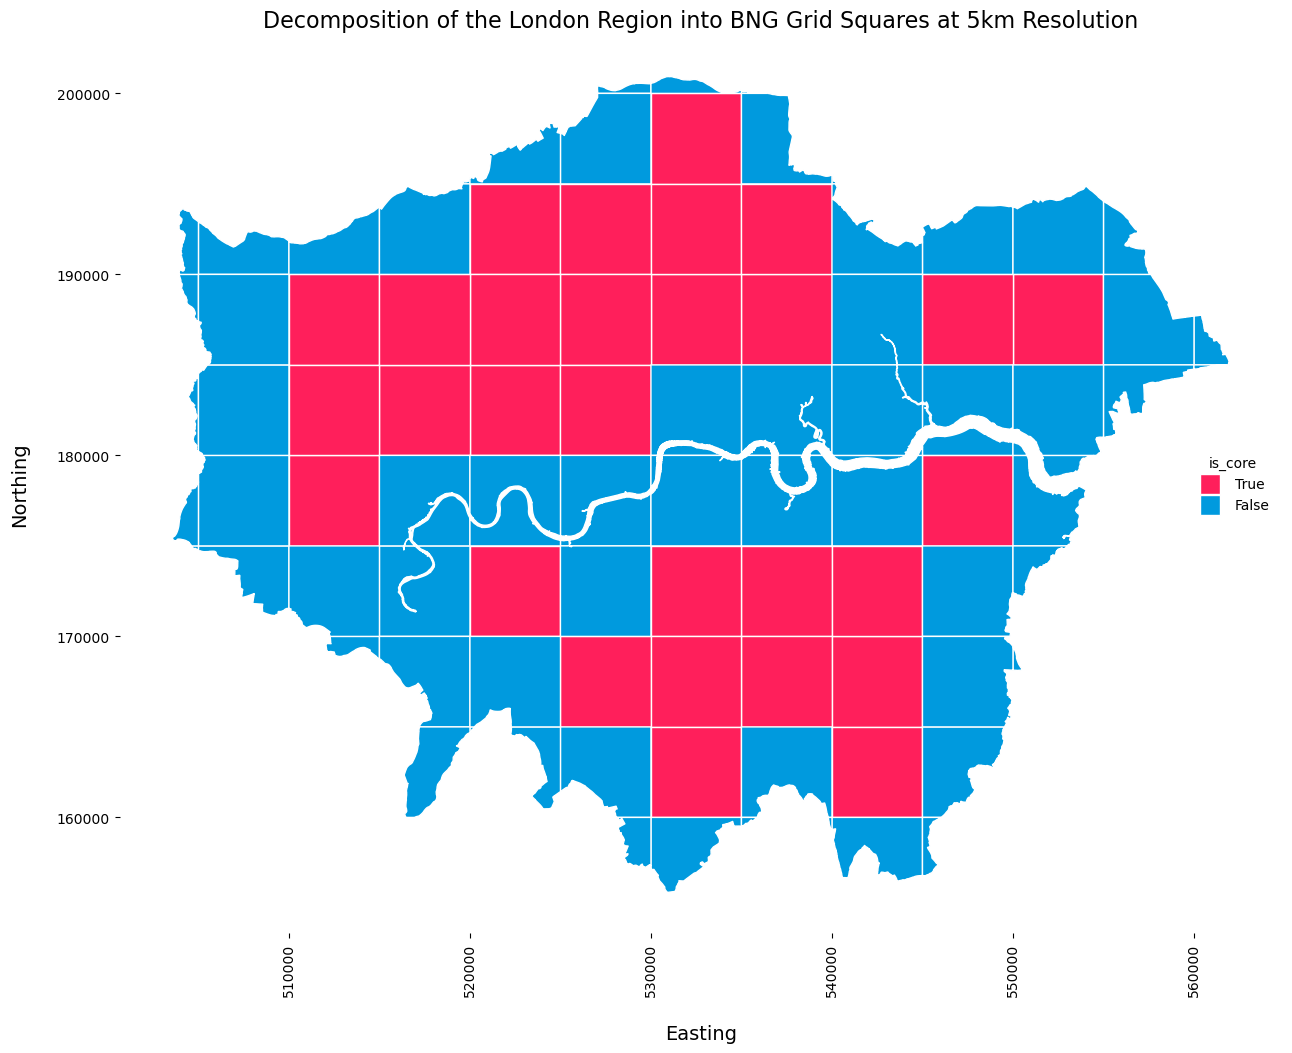

In [12]:
# Create matplotlib figure and axis
f, ax = plt.subplots(figsize=(15, 15))

# Plot the indexed and exploded London Region GeoDataFrame
_gdf_london_exp.plot(
    ax=ax,
    edgecolor="#fff",
    linewidth=1,
    color=["#ff1f5b" if is_core else "#009ade" for is_core in _gdf_london_exp["is_core"]],
)

# Set the title
ax.set_title(
    "Decomposition of the London Region into BNG Grid Squares at 5km Resolution",
    fontsize=16,
)

# Add a categorical legend for the is_core column
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label="True",
        markerfacecolor="#ff1f5b",
        markersize=14,
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label="False",
        markerfacecolor="#009ade",
        markersize=14,
    ),
]
# Add legend to the plot
legend = ax.legend(handles=legend_elements, title="is_core", loc="center right")
# Remove legend frame
legend.get_frame().set_linewidth(0)

# Set axis labels
ax.set_xlabel("Easting", fontsize=14)
ax.set_ylabel("Northing", fontsize=14)

# Remove the figure frame but keep the ticks and tick labels
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Rotate x axis tick labels by 90 degrees anticlockwise
plt.xticks(rotation=90)

# Add whitespace between x and y axis labels and tick labels
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20